<a href="https://colab.research.google.com/github/JayThibs/Weak-Supervised-Learning-Case-Study/blob/main/text_classifier/notebooks/05_toxicity_classification_snorkel_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating a Binary Classification Dataset of the Toxicity Dataset with Snorkel

In order to simplify the problem, we are going to turn this multi-label classification problem (does it contain any of these 'bad' labels?) to a binary classification problem (is it a 'bad' comment or not?).

We've already trained a multi-label model for this problem in notebook 01, so why are we doing this? We are doing this for a few reasons:

1. We want to test how well we can create labeling functions with Snorkel to build a dataset without knowing the labels.

2. It takes time to create many labeling functions that create a useful dataset, and it takes longer if it's for a multi-class classification problem, and even longer for multi-label classification. Therefore, in the interest of time, we will make the classification binary.

3. We want to try implementing Active Learning into our prototype and it will be simpler to start with a binary classification model.


Some of the code is borrowed from:

1. https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing#scrollTo=acF4YRlQL8iz

2. https://www.inovex.de/blog/snorkel-weak-superversion-german-texts/

3. https://trishalaneeraj.github.io/2020-07-26/data-labeling-weak-supervision

In [212]:
!pip install snorkel --quiet
!pip install datasets --quiet
!pip install spacy --quiet
!pip install pip install better-profanity --quiet
!pip install transformers --quiet
!pip install pytorch_lightning --quiet
# !python -m spacy download en_core_web_md --quiet

     |████████████████████████████████| 808kB 4.0MB/s 
     |████████████████████████████████| 276kB 31.5MB/s 
     |████████████████████████████████| 645kB 25.0MB/s 
     |████████████████████████████████| 829kB 36.2MB/s 
     |████████████████████████████████| 10.6MB 37.6MB/s 
     |████████████████████████████████| 1.3MB 36.5MB/s 
     |████████████████████████████████| 296kB 40.8MB/s 
     |████████████████████████████████| 143kB 43.4MB/s 
ERROR: snorkel 0.9.7 has requirement tensorboard<2.0.0,>=1.14.0, but you'll have tensorboard 2.4.1 which is incompatible.


In [214]:
import pandas as pd
from snorkel.labeling import labeling_function
from snorkel.labeling import LabelingFunction
from snorkel.labeling.lf.nlp import nlp_labeling_function
from snorkel.preprocess import preprocessor
from textblob import TextBlob
from better_profanity import profanity
from snorkel.labeling import PandasLFApplier
from sklearn.model_selection import train_test_split
import spacy
from spacy.matcher import Matcher
import numpy as np
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import PhraseMatcher

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
RANDOM_SEED = 42
pl.seed_everything(RANDOM_SEED)

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


42

## Data

Our dataset contains potentially offensive (toxic) comments and comes from the [Toxic Comment Classification Challenge](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge). Let's start by download the data (from Google Drive):

In [3]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
68.8MB [00:00, 84.2MB/s]


We can take a look at the data:

In [420]:
# we can see 
df = pd.read_csv("toxic_comments.csv")
df.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,0,0,0,0,0
1,000103f0d9cfb60f,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember what page that's on?",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the tools well. · talk """,0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0,0,0,0,0,0
8,00037261f536c51d,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contrary to those of DuLithgow,0,0,0,0,0,0


As we can see, we have comments from YouTube videos where most are clean comments, but there are some bad comments that are labeled as either: toxic,	severe_toxic,	obscene,	threat,	insult and/or	identity_hate. We will bunch them all together into the same label we will call 'labels' because Snorkel prefers this.

## Preprocessing

Let's have a look at the dataset before we start creating labeling functions.

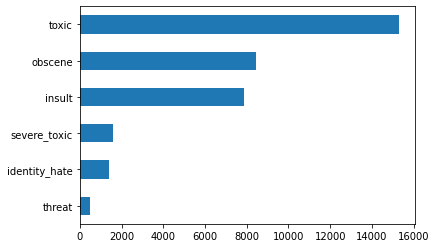

In [421]:
LABEL_COLUMNS = df.columns.tolist()[2:]
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

Now, let's add them all up together and compare them to the number of clean comments.

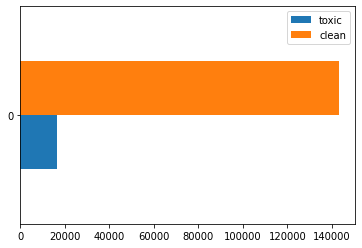

In [422]:
df_toxic = df[df[LABEL_COLUMNS].sum(axis=1) > 0]
df_clean = df[df[LABEL_COLUMNS].sum(axis=1) == 0]

pd.DataFrame(dict(
  toxic=[len(df_toxic)], 
  clean=[len(df_clean)]
)).plot(kind='barh');

The bad examples are imbalanced, but we will not worry about that. What we will do, however, is to eliminate clean examples from the dataset in order to make it more balanced. We will simply reduce the number of clean comments to a number that is comparable to the toxic comments.

In [423]:
train_df = pd.concat([
  df_toxic.sample(1500, random_state=42),
  df_clean.sample(1500, random_state=42)
])

print(len(train_df))
train_df.head()

3000


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
45045,786d8ca9b0bad3cc,"""\nI was talking about them running any check they want on ME to disprove your claims. I didn't know where you lived until you were silly enough to post an IP and connect your name to it. And yes you did post as an IP, and other places. You added your name at the end of the IP. And any fool can just enter """"locate x.x.x.x"""" in google and find where an ip is out of. We even have some tools here at wikipedia. YOU just outed yourself, which was quite foolish. Now please stay off my talk page. You have accused me of doing what you so foolishly have done yourself. - 2¢ © """,1,0,0,0,0,0
27198,47f18388952e3ee7,"White Trash\nFuck off you white piece of trash. Fucking wiggers. Go and fuck a Jew, Jew raper.",1,1,1,0,1,1
16664,2bf361b9a8eb1ba5,eat shit get rid of goofs you queers.,1,0,1,0,1,0
8158,15b6fd032e614001,"DUMB ASSES\nIt's was my sockpuppet...joe hazeton... you guys are out of control..... i am making a folder which will be submited to higher athority, one above the GOD KING JIMBO.... I WOULD STRONGLY SUGGEST YOU FIGURE IT OUT FAST...I DON'T MR BH will LIKE HIS FULL NAME PUBLISH ON WIKIPEDIA AS A NON-NOTABLE WITh charges of slander and libel forthwith... JOEHAZELTON...PS I DON't KNOW BRYAN OR DINO",1,0,0,0,0,0
142212,f8b05b9ae771fb50,"Are all professors of rhetoric pompous, self-centered assholes? Or is it just you?",1,0,1,0,1,0


### Merging All Toxic Comments Together

In [424]:
train_df['label'] = np.where(train_df[LABEL_COLUMNS].sum(axis=1) == 0, 0, 1)
train_df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label
88045,eb8cefa54813f3bc,"Thanks and bye\nJust wanted to thank you for making me feel at home when I post stuff, even when it's wrong. On your page, you come off as being arogant and unnapproachable but you have helped me, and treated me like an adult. Anyway, I will no longer be posting and have requested my acount to be deleted and have removed any posts in the discussion sections. Thanks for the warm welcome and always good to see another Maddox fan.",0,0,0,0,0,0,0
44474,76c473f8898626ce,"Seems to be at it again, in force",0,0,0,0,0,0,0
75044,c8cc3dca0745ba2f,"Still meaningless. It's a random example of Wikipedia providing coverage of a current event, as good as any other. It's absurd to mention it back in the article that the article has been mentioned somewhere.",0,0,0,0,0,0,0
103363,29236fd9f0ccd41e,I don't know. Is it a good idea to delete articles? Are there people who have heard of Paris but not of the Hurricanes?,0,0,0,0,0,0,0
130762,bb846cf699d149a4,"""\n\nActually, the NY Times made much the same point, as N&EG; pointed out in the discussion about this paper, @ """"New information casts doubt on hiatus"""", above. Why didn't you post this comment there?\n\nPerhaps we should combine the two news articles. We can't just ignore significant RS press commentary, especially on a brand-new primary-source paper. """,0,0,0,0,0,0,0


In [425]:
train_df = train_df.drop(LABEL_COLUMNS, axis=1)
train_df

,id,comment_text,label
45045,786d8ca9b0bad3cc,"""\nI was talking about them running any check they want on ME to disprove your claims. I didn't know where you lived until you were silly enough to post an IP and connect your name to it. And yes you did post as an IP, and other places. You added your name at the end of the IP. And any fool can just enter """"locate x.x.x.x"""" in google and find where an ip is out of. We even have some tools here at wikipedia. YOU just outed yourself, which was quite foolish. Now please stay off my talk page. You have accused me of doing what you so foolishly have done yourself. - 2¢ © """,1
27198,47f18388952e3ee7,"White Trash\nFuck off you white piece of trash. Fucking wiggers. Go and fuck a Jew, Jew raper.",1
16664,2bf361b9a8eb1ba5,eat shit get rid of goofs you queers.,1
8158,15b6fd032e614001,"DUMB ASSES\nIt's was my sockpuppet...joe hazeton... you guys are out of control..... i am making a folder which will be submited to higher athority, one above the GOD KING JIMBO.... I WOULD STRONGLY SUGGEST YOU FIGURE IT OUT FAST...I DON'T MR BH will LIKE HIS FULL NAME PUBLISH ON WIKIPEDIA AS A NON-NOTABLE WITh charges of slander and libel forthwith... JOEHAZELTON...PS I DON't KNOW BRYAN OR DINO",1
142212,f8b05b9ae771fb50,"Are all professors of rhetoric pompous, self-centered assholes? Or is it just you?",1
...,...,...,...
88045,eb8cefa54813f3bc,"Thanks and bye\nJust wanted to thank you for making me feel at home when I post stuff, even when it's wrong. On your page, you come off as being arogant and unnapproachable but you have helped me, and treated me like an adult. Anyway, I will no longer be posting and have requested my acount to be deleted and have removed any posts in the discussion sections. Thanks for the warm welcome and always good to see another Maddox fan.",0
44474,76c473f8898626ce,"Seems to be at it again, in force",0
75044,c8cc3dca0745ba2f,"Still meaningless. It's a random example of Wikipedia providing coverage of a current event, as good as any other. It's absurd to mention it back in the article that the article has been mentioned somewhere.",0
103363,29236fd9f0ccd41e,I don't know. Is it a good idea to delete articles? Are there people who have heard of Paris but not of the Hurricanes?,0


## Preparing the Data for Snorkel

In [426]:
train_df = train_df.rename(columns={"comment_text": "text"})
train_df.head()

,id,text,label
45045,786d8ca9b0bad3cc,"""\nI was talking about them running any check they want on ME to disprove your claims. I didn't know where you lived until you were silly enough to post an IP and connect your name to it. And yes you did post as an IP, and other places. You added your name at the end of the IP. And any fool can just enter """"locate x.x.x.x"""" in google and find where an ip is out of. We even have some tools here at wikipedia. YOU just outed yourself, which was quite foolish. Now please stay off my talk page. You have accused me of doing what you so foolishly have done yourself. - 2¢ © """,1
27198,47f18388952e3ee7,"White Trash\nFuck off you white piece of trash. Fucking wiggers. Go and fuck a Jew, Jew raper.",1
16664,2bf361b9a8eb1ba5,eat shit get rid of goofs you queers.,1
8158,15b6fd032e614001,"DUMB ASSES\nIt's was my sockpuppet...joe hazeton... you guys are out of control..... i am making a folder which will be submited to higher athority, one above the GOD KING JIMBO.... I WOULD STRONGLY SUGGEST YOU FIGURE IT OUT FAST...I DON'T MR BH will LIKE HIS FULL NAME PUBLISH ON WIKIPEDIA AS A NON-NOTABLE WITh charges of slander and libel forthwith... JOEHAZELTON...PS I DON't KNOW BRYAN OR DINO",1
142212,f8b05b9ae771fb50,"Are all professors of rhetoric pompous, self-centered assholes? Or is it just you?",1


In [427]:
dev_df = train_df.groupby('label').apply(lambda s: s.sample(100, random_state=123)).reset_index(level=0, drop=True)
train_df.drop(dev_df.index, inplace=True)

train_df, test_df = train_test_split(train_df, test_size=0.25)
val_df = test_df.sample(frac=0.1)
test_df.drop(val_df.index, inplace=True)

print('Train:', len(train_df), '\t Dev:', len(dev_df), '\t Test:', len(test_df), '\t', 'Valid:', len(val_df))

Train: 2100 	 Dev: 200 	 Test: 630 	 Valid: 70


In [428]:
train_df.to_csv('toxic_train_2100_examples.csv')
test_df.to_csv('toxic_test_630_examples.csv')
val_df.to_csv('toxic_val_70_examples.csv')
dev_df.to_csv('toxic_dev_200_examples.csv')

In [429]:
train_df.drop(['label'], axis=1, inplace=True)

## Writing Labeling Functions (LFs)

For clarity, we define constants to represent the class labels for non-toxic, toxic, and abstaining. These will go into our labeling functions so that the constants feed into the labeling process.

In [368]:
ABSTAIN = -1
NONTOXIC = 0
TOXIC = 1

In [166]:
# Useful for looking at the data and creating the labeling functions
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

Let's at a sample of the dataset so that we can come up with labeling functions.

In [167]:
dev_df

,id,text,label
39268,68caa6873247d5ac,Assad's mother flees Syria \n\nNotable as now only Bashar and his badly injured brother Maher survive in Syria as members of the Assad family: Assad's Mother Leaves Syria,0
101543,1f73989aee291e63,"""\nI'll give you my decision in one week. At this time, I'm far too upset about everything that happened to make any decision. '''''' """,0
123763,95f6434cda9fc452,"""\nComment While the """"it's the main one"""" argument is a nasty one - if the US version was the original (which I'm not rightly sure of), wouldn't it be the originator? Perhaps the US version should have a section listing the international versions (if related)? Of course, this is all assuming the US one was first and the others are descendants. """,0
11683,1ee3041555207c09,Just because we have a mediation going on (to which you have not even responded for two weeks) does not mean that I shouldn't contribute to Wikipedia. I am afraid you have demonstrated that you have zero tolerance for views differing from your own.,0
49611,84a1e57f1a1fdd47,"""::::::::Well, then. So you HAD heard of him prior to this thread and precisely for the work that is applicable here.\n \nAs for the """"impact"""" part of your statement it is entirely irrelevant to the question at hand. As a journalist he is not expected to have an """"impact"""", he is merely expected to report on it ... which he does as a professional employed by a prominent national Canadian news outlet. When we quote writers from say, The New York Times or the Washington Post, we don't question whether the authors of those pieces have """"impacted"""" the debate or not because it is merely their reporting on the people who DO have an impact that matters.\n\nYou can't deny that he has written extensively on the subject of GW Deniers, his record is there for all to see, and this makes him particularly relevant to the specific criticisms that he raises, namely the methods used by opponents of the GW Deniers to smear and misrepresent them. Thank you for making my point. \n\n""",0
31171,52c9746a50f5828f,"""\n\n VoABOT query \n\nHiya.\n\n placed an RPP here, and immediately after it was removed by VoABot .\n\nThe actual page has now been protected, so that isn't a concern, but I'm not sure why the bot removed it; I think that the other requests removed at the same time were indeed closed, but this one had no action.\n\nThanks in anticipation, ► """,0
36129,608a3e3ef79a6987,"""\nActually, Nin Einne is right. I'll try to explain why. First thing: all scientific information (i.e. somewhat accurate info...) should be publically verifyable, where verifyable means that one can check whatever is claimed, and public refers to the fact that anyone can do that. Now, if you cite some source, like in the example above, it says """"blah blah near daily""""(citation number). Unlike what you might think, that does not mean that the sentence """"blah blah near daily"""" is a universally accepted fact as proven by the fact that you have another opinion. What the phrase """"blah blah near daily""""(citation number) actually means is """"in (citation number), someone claims blah blah near daily"""", which, you'll agree, is fully correct. After all, that is what's written there and anyone can look at the source (because it's public) and read what is says (verifyable). Now, if you think that blah blah occured daily an not near daily, that is fine. But how should you go about it ? One thing you can not do: change the sentence and leave the citation! Because then it would mean: """"in (citation number), someone claims blah blah daily"""". That is not true! If you look at the source, you'll see it says """"blah blah near daily""""! Which is just what Nil Einne pointed out. Of course it can happen that what's written in the source is not accurate. But that doesn't mean you have the right to change it as you did.\nWhat you can do is add another source that contradicts the first one. You could write It has been rep

In [168]:
# Showing the most common words to make the labeling function creation process quicker
# This is where we can come up with a custom keyword list

pd.Series(' '.join(dev_df[dev_df['label'] == 1].sample(100, random_state=42).text).split()).value_counts()[:100]

a            407
your         345
dickhead     308
you          274
me           161
can't        143
is           138
down         138
keep         138
nigger       135
the          102
gayfrozen     93
to            86
I             80
OF            78
ABUSING       76
LATINUS       76
PROOF         76
POWER         75
and           67
of            63
that          50
are           45
You           33
my            32
for           29
it            28
not           27
was           23
"             22
do            20
in            20
with          19
like          19
on            18
have          17
be            16
this          16
as            15
can           15
should        15
think         14
but           13
YOU           13
don't         13
know          13
so            12
from          12
A             12
which         12
i             12
will          11
I'm           11
just          11
get           10
because       10
some          10
what          10
fuck          

### Labeling Functions

In [169]:
@nlp_labeling_function()
def contains_work_of_art(x):
    """If comment contains titles of books, songs, etc., label non-toxic, else abstain"""
    if any([ent.label_ == "WORK_OF_ART" for ent in x.doc.ents]):
        return NONTOXIC
    else:
        return ABSTAIN
    
@nlp_labeling_function()
def contains_entity(x):
    """If comment contains least 3 mentions of an entity, label non-toxic, else abstain"""
    if len([ent.label_ in ["PERSON", "GPE", "LOC", "ORG", "LAW", "LANGUAGE"] for ent in x.doc.ents])>2:
        return NONTOXIC
    else:
        return ABSTAIN

In [170]:
@preprocessor(memoize=True)
def textblob_sentiment(x):
    scores = TextBlob(x.text)
    x.polarity = scores.sentiment.polarity
    x.subjectivity = scores.sentiment.subjectivity
    return x

@labeling_function(pre=[textblob_sentiment])
def textblob_polarity(x):
    """If comment has a polarity score between +0.9 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.polarity > 0.9 else ABSTAIN

@labeling_function(pre=[textblob_sentiment])
def textblob_subjectivity(x):
    """If comment has a subjectivity score between +0.7 and +1, label non-toxic, else abstain"""
    return NONTOXIC if x.subjectivity >= 0.7 else ABSTAIN

In [171]:
# @labeling_function()
# def contains_profanity(x):
#     """
#     If comment contains profanity label toxic, else abstain. 
#     Profanity determined using this library - https://github.com/snguyenthanh/better_profanity
#     """
#     return TOXIC if profanity.contains_profanity(x.text) else ABSTAIN

In [192]:
# @nlp_labeling_function()
# def contains_pleaseread(x):
#     """
#     Will match commonly occuring phrases like - 
#     Please read this
#     Please read the
#     Please read
#     """
#     matcher = PhraseMatcher(nlp.vocab)
#     pattern = [{"LEMMA": "please"},
#                {"LEMMA": "read"},
#                {"LEMMA": "the", "OP": "?"},
#                {"LEMMA": "this", "OP": "?"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

@nlp_labeling_function()
def contains_stopvandalizing(x):
    """
    Will match commonly occuring phrases like - 
    stop vandalizing
    do not vandalize
    don't vandalize
    """
    matcher = Matcher(nlp.vocab)
    pattern1 = [{"LEMMA": "do"},
                {"LEMMA": "not"},
                {"LEMMA": "vandalize"}]
    pattern2 = [{"LEMMA": "stop"}, 
                {"LEMMA": "vandalize"}]
    matcher.add("p1", None, pattern1)
    matcher.add("p2", None, pattern2)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
# @nlp_labeling_function()
# def contains_harassme(x):
#     """
#     Will match commonly occuring phrases like - 
#     harass me
#     harassed me
#     harassing me
#     """
#     matcher = Matcher(nlp.vocab)
#     pattern = [{"LOWER": "harass"}, 
#                {"LOWER": "me"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

# @nlp_labeling_function()
# def contains_willreport(x):
#     """Will match commonly observed phrases like - 
#     report you
#     reported you
#     reporting you
#     reported your
#     """
#     matcher = Matcher(nlp.vocab)
#     pattern = [{"LEMMA": "report"}, 
#                {"LEMMA": "you"}]
#     matcher.add("p1", None, pattern)
#     matches = matcher(x.doc)
#     return NONTOXIC if len(matches)>0 else ABSTAIN

In [193]:
@nlp_labeling_function()
def contains_email(x):
    """If comment contains email address, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_EMAIL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN
    
@nlp_labeling_function()
def contains_url(x):
    """If comment contains url, label non-toxic, else abstain"""
    matcher = Matcher(nlp.vocab)
    pattern = [{"LIKE_URL": True}]
    matcher.add("p1", None, pattern)
    matches = matcher(x.doc)
    return NONTOXIC if len(matches)>0 else ABSTAIN

In [194]:
def keyword_lookup(x, keywords, label):
    if any(word in x.text.lower() for word in keywords):
        return label
    return ABSTAIN

def make_keyword_lf(keywords, label=TOXIC):
    return LabelingFunction(
        name=f"keyword_{keywords[0]}",
        f=keyword_lookup,
        resources=dict(keywords=keywords, label=label),
    )

# with open('badwords.txt') as f:
#     toxic_stopwords = f.readlines()

# toxic_stopwords = [x.strip() for x in toxic_stopwords] # len = 458
# """Comments mentioning at least one of Google's Toxic Stopwords 
# https://code.google.com/archive/p/badwordslist/downloads are likely toxic"""
# keyword_toxic_stopwords = make_keyword_lf(keywords=toxic_stopwords)

keyword_please = make_keyword_lf(keywords=["please", "plz", "pls", "pl", "Please read this", "Please read the", "Please read"], label=NONTOXIC)

keyword_thanks = make_keyword_lf(keywords=["thanks", "thank you", "thx", "tx"], label=NONTOXIC)

In [195]:
# @labeling_function()
# def capslock(x):
#     """If comment is written in all caps, label toxic, else abstain"""
#     return TOXIC if x.text == x.text.upper() else ABSTAIN

#### Creating BERT sentiment model for labeling

In [215]:
BERT_MODEL_NAME = "nlptown/bert-base-multilingual-uncased-sentiment"

In [227]:
model = AutoModelForSequenceClassification.from_pretrained(BERT_MODEL_NAME)
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

In [217]:
MAX_TOKEN_COUNT = 512

In [219]:
dev_df

['id', 'text', 'label']

In [ ]:
data_row = dev_df.iloc[10]

comment_text = data_row.text
labels = data_row['label']

print(sample_comment)
print()
print(sample_labels.to_dict())

In [ ]:
encoding = self.tokenizer.encode_plus(
  comment_text,
  add_special_tokens=True,
  max_length=self.max_token_len,
  return_token_type_ids=False,
  padding="max_length",
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

In [ ]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    comment_text = data_row.comment_text
    labels = data_row['label']

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
train_dataset = ToxicCommentsDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

In [ ]:
class ToxicCommentDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = ToxicCommentDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
class ToxicCommentTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

In [ ]:
model = ToxicCommentTagger(
  n_classes=2,
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

In [228]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
sentiment_pipeline(str("The problem with saying that Warren G. Harding was the first African-American President is that it"))[0]

{'label': '3 stars', 'score': 0.3299042284488678}

In [229]:
sample_comment = "The problem with saying that Warren G. Harding was the first African-American President is that it"

In [370]:
spacy_tokenizer = nlp.tokenizer
tokens = spacy_tokenizer("This is a sentence")
len(tokens)

4

In [233]:
sentiment_pipeline('this video was fucking awesome')[0].values()

dict_values(['5 stars', 0.7866018414497375])

In [377]:
@labeling_function()
def lf_bert_sentiment(x):
    """ Hatespeech may have a negative sentiment.
        
    Ranks the text given a sentiment from a pretrained bert transformer for movie reviews sentiment analysis.
    Note: For larger datasets, we should compute this in batches and ahead-of-time.
    """

    # encoding = tokenizer.encode_plus(
    #   x.text,
    #   add_special_tokens=False,
    #   max_length=256,
    #   return_token_type_ids=False,
    #   padding="max_length",
    #   truncation=True,
    #   return_attention_mask=False,
    #   return_tensors='pt',
    # )

    # print(encoding['input_ids'].squeeze().size())

    # tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())
    # string_of_tokens = " ".join(tokens)
    # print(string_of_tokens)
    # print(len(string_of_tokens))

    try:
      label, proba = sentiment_pipeline(x.text)[0].values()
      if label == '1 star' and proba >= 0.5:
          return TOXIC
      if label == '3 star' and proba >= 0.5:
          return NONTOXIC
      if label == '4 star' and proba >= 0.5:
          return NONTOXIC
      if label == '5 star' and proba >= 0.5:
          return NONTOXIC
      return ABSTAIN

    except:
      return ABSTAIN

In [391]:
lfs = [
      contains_work_of_art,
      contains_entity,
      # textblob_polarity,          # Removed: only labeled 2 examples with 50% accuracy
      # textblob_subjectivity,    # Removed: 35% accuracy
      # contains_profanity,       # Removed: 62% accuracy, removed to make labeling faster
      # contains_pleaseread,
      # contains_stopvandalizing,
      # contains_harassme,        # Removed: 50% on 4 examples
      # contains_willreport,      # Removed: labels 1 example and gets it wrong
      contains_email,
      contains_url,
      # keyword_toxic_stopwords,  # Removed: 22% accuracy
      keyword_please,
      keyword_thanks,
      # capslock                  # Removed: 55% accuracy, doesn't label many examples
      lf_bert_sentiment
]

## Applying the Labeling Functions

In [392]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=train_df)

Streaming output truncated to the last 5000 lines.











 94%|█████████▎| 1967/2100 [08:07<00:24,  5.49it/s]










































 94%|█████████▍| 1969/2100 [08:07<00:20,  6.41it/s]










































 94%|█████████▍| 1971/2100 [08:08<00:27,  4.74it/s]










































 94%|█████████▍| 1972/2100 [08:08<00:26,  4.88it/s]










































 94%|█████████▍| 1973/2100 [08:08<00:22,  5.54it/s]










































 94%|█████████▍| 1974/2100 [08:09<00:37,  3.34it/s]










































 94%|█████████▍| 1975/2100 [08:09<00:40,  3.06it/s]










































 94%|█████████▍| 1976/2100 [08:10<01:10,  1.75it/s]










































 94%|█████████▍| 1977/2100 [08:12<01:33,  1.32it/s]










































 94%|█████████▍| 1978/2100 [08:12<01:10,  1.74it/s]










































In [393]:
L_dev = applier.apply(df=dev_df)

Streaming output truncated to the last 5000 lines.











 36%|███▌      | 71/200 [00:19<00:40,  3.21it/s]










































 36%|███▌      | 72/200 [00:20<01:12,  1.77it/s]










































 36%|███▋      | 73/200 [00:20<01:15,  1.69it/s]










































 37%|███▋      | 74/200 [00:21<01:12,  1.74it/s]










































 38%|███▊      | 75/200 [00:21<00:55,  2.23it/s]










































 38%|███▊      | 76/200 [00:21<00:54,  2.29it/s]










































 38%|███▊      | 77/200 [00:22<00:45,  2.72it/s]










































 40%|███▉      | 79/200 [00:22<00:34,  3.55it/s]










































 40%|████      | 80/200 [00:22<00:32,  3.69it/s]










































 40%|████      | 81/200 [00:22<00:30,  3.87it/s]










































 41%|████      | 82/200 [00:

In [394]:
import pickle

with open('L_train_toxic_pretrained_bert_1.pkl','wb') as f:
  pickle.dump(L_train, f)
with open('L_train_toxic_pretrained_bert_1.pkl','rb') as f:
  L_train = pickle.load(f)
  print(L_train.shape)

(2100, 7)


In [395]:
L_train

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1,  1],
       ...,
       [-1,  0, -1, ..., -1, -1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1,  1]])

In [396]:
from snorkel.labeling import LFAnalysis
LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
contains_work_of_art,0,[0],0.060000,0.055238,0.010476
contains_entity,1,[0],0.304762,0.236667,0.103333
contains_email,2,[0],0.000952,0.000952,0.000476
contains_url,3,[0],0.026667,0.020476,0.008095
keyword_please,4,[0],0.311905,0.239524,0.109048
keyword_thanks,5,[0],0.082857,0.059524,0.014762
lf_bert_sentiment,6,[1],0.384286,0.171429,0.171429


In [397]:
from snorkel.labeling.model import LabelModel

label_model = LabelModel(cardinality=2, verbose=True)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

In [398]:
dev_df

,id,text,label
75562,ca209ba9f5e6c427,"""\n\nQuoting it in full:\n\n A7. No indication of importance (individuals, animals, organizations, web content).\n An article about a real person, individual animal(s), organization (e.g. band, club, company, etc., except schools),Past discussions leading to schools being exempt from A7. or web content that does not indicate why its subject is important or significant. This is distinct from verifiability and reliability of sources, and is a lower standard than notability. This criterion applies only to articles about web content and to articles about people, organizations, and individual animals themselves, not to articles about their books, albums, software, or other creative works. This criterion does not apply to species of animals, only to individual animal(s). The criterion does not apply to any article that makes any credible claim of significance or importance even if the claim is not supported by a reliable source or does not qualify on Wikipedia's notability guidelines.It is irrelevant whether the claim of notability within the article falls below the notability guidelines. If the claim is credible, the A7 tag can not be applied. The criterion does apply if the claim of significance or importance given is not credible. If the claim's credibility is unclear, you can improve the article yourself, propose deletion, or list the article at articles for deletion.\n , – for people, – for bands, – for clubs, societies, groups, and organizations, – for companies and corporations, – for websites, – for individual animals\n\nPlease note the bolded text.""",0
132186,c35ee1f2038ebd08,"File:Hurricane-Katrina-Grand-Casino-Gulfport-hotel-EPA.jpg\nHi. If you'd be able to track down the source description page and info for File:Hurricane-Katrina-Grand-Casino-Gulfport-hotel-EPA.jpg which you uploaded here a while back and is now on Commons, that would be great, thanks! Thanks for your work. Cheers,",0
3704,09e68df5ff03c01f,"message from you regarding THREATS, STALKING, HARASSMENT, VIOLATION OF TERMS OF SERVICE AND CYBER BULLING FROM USER KERI.\n\nUser Keri has engaged in a pattern of threat, harassment, stalking and cyberbullying against me despite my telling them never to contact me again.\nNext I got an implicit threat from you alleging a legal threat involving me. The conduct that user KERI is involved in are all illegal and I have repeatedly demanded that user stop contacting me. Stop using your position of authority to takes sides with the mods and admins against the 99% by censoring us and trying to intimidate us.",0
42542,718a3018dc34e106,"I'll give you the benefit of the doubt as an experienced editor; however, in my personal opinion, we do not need a redirect to every article title from every conceivable grammatical variant of the title which might theoretically be used in a sentence. That's what piped links are for. (call me Russ)",0
110576,4f8eeca4ccf6d666,"Communists Appearing on Iranian TV + Are They Having A Laugh? \n\nThat is the question. History students will know that Communists inspired the Iranian Revolution in 1979 and did the heavy lifting. They were then butchered by the Ayatollah and his followers. So, what kind of a Leftie would make an appearance on Press TV, which is run by the same Govt? Some kind of a Useful Idiot, that's who!",0
40861,6d0ed912c0293979,I'll revise the criticism when A520 does. The unprofessional behaviour of this user indicates he ought not to have admin privileges. He has been reported for abuse of authority.,0
39876,6a7407a8b3b92b58,"""\n\n Dan56 is bullying contributors \n\nWhy are you guys allowing this one guy to control the page? He will not allow anything true to be put, only his own opinion. Metacritic gives the album a 76. That means """"generally positive."""" That's a very nice review. Why does Dan56 keep removing that when I add it? His opinion should not count more than the 14 critics cited. Please help with fairness. I understand he loves

In [399]:
Y_dev = dev_df.label.values
LFAnalysis(L_dev, lfs).lf_summary(Y_dev)

,j,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
contains_work_of_art,0,[0],0.035,0.035,0.010,5,2,0.714286
contains_entity,1,[0],0.320,0.290,0.150,43,21,0.671875
contains_email,2,[],0.000,0.000,0.000,0,0,0.000000
contains_url,3,[0],0.040,0.030,0.025,5,3,0.625000
keyword_please,4,[0],0.365,0.290,0.155,49,24,0.671233
keyword_thanks,5,[0],0.100,0.065,0.015,17,3,0.850000
lf_bert_sentiment,6,[1],0.475,0.220,0.220,72,23,0.757895


In [403]:
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
tokenizer = TweetTokenizer(preserve_case=False)
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize, ngram_range=(1, 3))

In [404]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=42)

In [405]:
from snorkel.labeling import filter_unlabeled_dataframe
from snorkel.utils import probs_to_preds
snorkel_label_probs = label_model.predict_proba(L=L_train)
X, y = filter_unlabeled_dataframe(X=train_df.text, y=snorkel_label_probs, L=L_train)
X = vectorizer.fit_transform(X)
classifier.fit(X, probs_to_preds(probs=y))

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [433]:
X = vectorizer.transform(dev_df.text.tolist())
y_true = dev_df.label.values    
y_pred = classifier.predict(X)

In [434]:
pd.DataFrame(y_pred).sum()

0    64
dtype: int64

In [435]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred, labels=[0,1]))

              precision    recall  f1-score   support

           0       0.66      0.90      0.76       100
           1       0.84      0.54      0.66       100

    accuracy                           0.72       200
   macro avg       0.75      0.72      0.71       200
weighted avg       0.75      0.72      0.71       200

